In [3]:
import xgboost as xgb
import polars as pl
from polars import col, lit
from database import connectorx_url, engine, sqlalchemy_url
import datetime
import pandas as pd

import mlflow

In [4]:
mlflow_tracking_uri = sqlalchemy_url + "/postgres?options=-csearch_path%3Ddbo,mlflow"

In [5]:
mlflow.set_tracking_uri(mlflow_tracking_uri)
# mlflow.create_experiment('waterbody_white_fraction_xgb', artifact_location='s3://deployment-zone-117819748843/mlflow/')
mlflow.set_experiment('waterbody_white_fraction_xgb')
mlflow.autolog()

2023/08/20 00:47:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/08/20 00:47:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [6]:
start_date = datetime.date(2021, 6, 1)

end_date = datetime.date(2023, 8, 15)
time_delta: datetime.timedelta = (end_date - start_date)

train_test_split_fraction = 0.6
split_date = start_date + (train_test_split_fraction * time_delta)

split_date

datetime.date(2022, 9, 27)

In [10]:
images_df = pd.read_sql(f"""
    
        WITH images AS (
            SELECT waterbody_id, "date", AVG(white_fraction) AS white_fraction 
            FROM (SELECT *, captured_ts::date AS "date" FROM waterbody_satellite_images) t1
            GROUP BY waterbody_id, "date"
        )
    
        SELECT 
            --id,
            images."date", 
            date_part('year', images."date")::integer as year, 
            date_part('month', images."date")::integer as month,
            date_part('doy', images."date")::integer as day_of_year,    
            b.latitude::float8, 
            b.longitude::float8,  
            white_fraction
                                
        FROM images
        INNER JOIN training_waterbody_ids ids --Inner join to remove data with no satellite imagery
        ON images.waterbody_id = ids.id
        LEFT JOIN water_bodies b
        ON b.id = ids.id
        WHERE images."date" BETWEEN '{start_date.strftime('%Y-%m-%d')}'::date AND '{end_date.strftime('%Y-%m-%d')}'::date
    """, 
    con=engine.connect()
)

In [47]:
images_df = images_df.dropna()
images_df

,date,year,month,day_of_year,latitude,longitude,white_fraction
0,2023-08-15,2023,8,227,44.443138,-97.004143,0.000000
1,2023-07-31,2023,7,212,44.443138,-97.004143,0.000000
2,2023-07-26,2023,7,207,44.443138,-97.004143,0.000000
3,2023-07-06,2023,7,187,44.443138,-97.004143,0.000000
4,2023-06-11,2023,6,162,44.443138,-97.004143,0.000000
...,...,...,...,...,...,...,...
67943,2021-08-31,2021,8,243,48.818970,-87.834328,0.000000
67944,2021-08-16,2021,8,228,48.818970,-87.834328,0.000000
67945,2021-07-02,2021,7,183,48.818970,-87.834328,0.178612
67946,2021-06-17,2021,6,168,48.818970,-87.834328,0.000000


In [12]:
training_features = [
    "year", "month", "day_of_year", "latitude", "longitude"
]

target_feature = "white_fraction"

In [13]:
train = images_df[images_df["date"] < split_date]

test = images_df[images_df["date"] >= split_date]

X_train = train[training_features]
y_train = train[target_feature]

X_test = test[training_features]
y_test = test[target_feature]

# test.select(pl.count())
y_train

23       0.000000
24       0.000000
25       0.000000
26       0.000000
27       0.000000
           ...   
67943    0.000000
67944    0.000000
67945    0.178612
67946    0.000000
67947    0.000000
Name: white_fraction, Length: 44511, dtype: float64

In [86]:
reg = xgb.XGBRegressor(
        n_estimators=20,
        early_stopping_rounds=3,
        learning_rate=0.3,
        max_depth=4,
        subsample=0.1,
        colsample_bytree=0.7,
        # base_score=0
        # tree_method='gpu_hist' 
        
)

reg.fit(X_train.to_numpy(), 
        y_train.to_numpy(),
        eval_set=[(X_test.to_numpy(), y_test.to_numpy())], # (X_train, y_train),
        verbose=1
)

reg.save_model("white_fraction_model.json")

2023/08/20 22:31:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '345a42639cc544d48bfdfed3c29a151c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-rmse:0.45850
[1]	validation_0-rmse:0.35821
[2]	validation_0-rmse:0.29607
[3]	validation_0-rmse:0.29472
[4]	validation_0-rmse:0.26190
[5]	validation_0-rmse:0.25023
[6]	validation_0-rmse:0.25025
[7]	validation_0-rmse:0.23659
[8]	validation_0-rmse:0.23277
[9]	validation_0-rmse:0.23082
[10]	validation_0-rmse:0.22975
[11]	validation_0-rmse:0.23197
[12]	validation_0-rmse:0.23219
[13]	validation_0-rmse:0.23138


In [15]:
reg.best_iteration

10

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

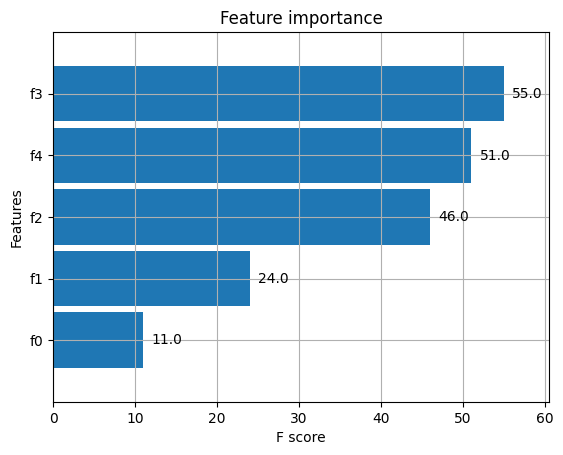

In [83]:

from xgboost import plot_importance, plot_tree

plot_importance(reg, height=0.9)

In [84]:

test_pred = reg.predict(X_test)

test_with_pred = test.copy()
test_with_pred[f"predicted_{target_feature}"] = test_pred

import plotly.express as px

px.scatter(test_with_pred, x="date", y=[target_feature, f"predicted_{target_feature}"])

2023/08/20 22:30:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [19]:
mlflow.last_active_run()

<Run: data=<RunData: metrics={'best_iteration': 10.0,
 'stopped_iteration': 13.0,
 'validation_0-rmse': 0.22974969256235023}, params={'base_score': 'None',
 'booster': 'None',
 'colsample_bylevel': 'None',
 'colsample_bynode': 'None',
 'colsample_bytree': '0.7',
 'custom_metric': 'None',
 'early_stopping_rounds': '3',
 'eval_metric': 'None',
 'gamma': 'None',
 'gpu_id': 'None',
 'grow_policy': 'None',
 'interaction_constraints': 'None',
 'learning_rate': '0.3',
 'max_bin': 'None',
 'max_cat_threshold': 'None',
 'max_cat_to_onehot': 'None',
 'max_delta_step': 'None',
 'max_depth': '4',
 'max_leaves': 'None',
 'maximize': 'None',
 'min_child_weight': 'None',
 'monotone_constraints': 'None',
 'n_jobs': 'None',
 'num_boost_round': '20',
 'num_parallel_tree': 'None',
 'objective': 'reg:squarederror',
 'predictor': 'None',
 'random_state': 'None',
 'reg_alpha': 'None',
 'reg_lambda': 'None',
 'sampling_method': 'None',
 'scale_pos_weight': 'None',
 'subsample': '0.1',
 'tree_method': 'None',

In [87]:
model = xgb.Booster()
model.load_model("white_fraction_model.json")

import numpy as np


model.predict(
    xgb.DMatrix(
        data=[[2023.0,2.0, 62.0,44.443138,-97.004143 ]]
    ) 
)

array([0.8386572], dtype=float32)